In [45]:
import pandas as pd
import re
import pymorphy2 as pm

### Посмотрим, сколько статей есть о каждом событии

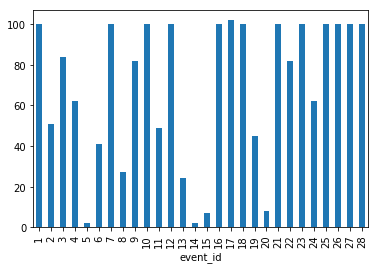

In [46]:
%matplotlib inline 
news = pd.read_csv('raw_news.csv', index_col=0)
number_of_articles = news.groupby('event_id').size()
number_of_articles.plot.bar()

## Часть 1. Предобработка

In [47]:
morph = pm.MorphAnalyzer()#лемматизируем с помощью pymorphy. работает долго)
def words(str):
    nolinks = ' '.join([word for word in str.split() if (not re.findall('https?://\w.*|\w+\.\w+', word))])#удалили ссылки
    clean_line = re.sub('[\W\d_-]+', ' ', nolinks.lower().strip())
    ws = re.split(' +', clean_line)
    return [morph.parse(w)[0].normal_form for w in ws]
df = pd.read_csv('raw_news.csv', index_col=0)
no_dup_df = df.drop_duplicates(keep='first')
texts = no_dup_df['text'] #прочитали тексты
text_list = [' '.join(words(text)) for text in texts] # список списков слов 


## Часть 2.  Кластеризация (28 кластеров)

In [48]:
from __future__ import print_function


from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,3), analyzer='word')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=133)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=28))
])

pipeline.fit(text_list)
#применили все методы, которые были в лабораторной.как сингулярное разложение и tfidf влияют на качество кластеризации надо
#посмотреть на нескольких примерах и придумать, как их вывести (сингулярное вроде не особо, tfidf очень сильно)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 99%


In [72]:
from __future__ import print_function

from sklearn import cluster
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,3), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=133)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=28))
])

pipeline.fit(text_list)
#применили все методы, которые были в лабораторной.как сингулярное разложение и tfidf влияют на качество кластеризации надо
#посмотреть на нескольких примерах и придумать, как их вывести (сингулярное вроде не особо, tfidf очень сильно)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 99%


In [73]:
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.10, ngram_range=(1,5), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=50)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=28))
])

pipeline.fit(text_list)

explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 61%


In [74]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

28
Homogeneity: 0.842320662772
Completeness: 0.81630096602
V-measure 0.829106721851
Adjusted Rand-Index: 0.673367377802


# а если не делать tfidf

In [75]:
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,3), analyzer='word', stop_words='english')),
      ('svd', TruncatedSVD(n_components=133)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=28))
])

pipeline.fit(text_list)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 99%


In [76]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

28
Homogeneity: 0.600610158424
Completeness: 0.580571123067
V-measure 0.590420657127
Adjusted Rand-Index: 0.366558186884


### А теперь спектральная кластеризация

In [77]:
#spectral clustering
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,2), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=100)),
      ('norm', Normalizer() ),
      ('clust', SpectralClustering(n_clusters=28))
])

pipeline.fit(text_list)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 93%


In [78]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

28
Homogeneity: 0.663870803236
Completeness: 0.641997201689
V-measure 0.652750808433
Adjusted Rand-Index: 0.42098049905


## Аггломеративная кластеризация

In [84]:
#Agglomerative Clustering
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,3), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=133)),
      ('norm', Normalizer() ),
      ('clust', AgglomerativeClustering(n_clusters=28))
])

pipeline.fit(text_list)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 99%


In [85]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

28
Homogeneity: 0.676961791261
Completeness: 0.659259792026
V-measure 0.667993535351
Adjusted Rand-Index: 0.437474228535


# Часть 3. Задали маленькое число кластеров

In [53]:
text_list2 = text_list
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1,5), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=130)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=5))
])

pipeline.fit(text_list2)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 79%


In [54]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
#как видно из результатов, полнота высокая, а вот Homogeneity сильно упала по сравнению с теми же параметрами, но для 28 кластеров
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

5
Homogeneity: 0.428304229595
Completeness: 0.879793954149
V-measure 0.576133315399
Adjusted Rand-Index: 0.239332482077


In [82]:
#spectral clustering
text_list2 = text_list
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1,5), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=130)),
      ('norm', Normalizer() ),
      ('clust', SpectralClustering(n_clusters=5))
])

pipeline.fit(text_list2)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 79%


In [83]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

5
Homogeneity: 0.313822323256
Completeness: 0.703191365547
V-measure 0.43397085105
Adjusted Rand-Index: 0.130648287708


In [86]:
#HAC
text_list2 = text_list
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1,5), analyzer='word', stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=130)),
      ('norm', Normalizer() ),
      ('clust', AgglomerativeClustering(n_clusters=5))
])

pipeline.fit(text_list2)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 79%


In [87]:
clust_labels = pipeline.named_steps['clust'].labels_
labels = no_dup_df['event_id']
print(len(set(clust_labels)))
print("Homogeneity:", homogeneity_score(labels, clust_labels))
print("Completeness:", completeness_score(labels, clust_labels))
print("V-measure",  v_measure_score(labels, clust_labels))
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

5
Homogeneity: 0.390910045628
Completeness: 0.880725664889
V-measure 0.541482921563
Adjusted Rand-Index: 0.180692931037


In [55]:
#не очень симпатинчй
class TextProcessor():
    def __init__(self):
        self.ws = {}
    def send(self, word):
        if(not (word in self.ws)):
            self.ws[word] = 0
        self.ws[word] += 1
    def words(self):
        return self.ws
    def sorted(self, count):
        all = sorted(list(self.ws.items()), key=lambda w: -w[1])
        return all[:count]
realKeys = {}
for i in range(len(clust_labels)):
    if (not clust_labels[i] in realKeys):
        realKeys[clust_labels[i]] = []
    realKeys[clust_labels[i]].append(labels[i])
realSorted = {}
for k, v in realKeys.items():
    proc = TextProcessor()
    for w in v:
        proc.send(w)
    realSorted[k] = proc.sorted(100)
print(realSorted)

KeyError: 513

In [56]:
ef = pd.read_csv('events.csv', index_col=0)
evs = {}
for k in range(len(ef['name'])):
     evs[k + 1] = ef['name'][k+1]

In [57]:
pretty = {}
for k, v in realSorted.items():
    pretty[k] = [(evs[e[0]], e[1]) for e in v]
print(pretty)

NameError: name 'realSorted' is not defined